# Minimax Depth vs Move-Time Analysis
In this notebook, we explore the relationship between the **depth** parameter of the Minimax algorithm and **move-time** during gameplay in Othello. 

Essentially, we must understand the time it takes for our AI to make moves. The core hypothesis is based on the theoretical understanding that the complexity of the Minimax algorithm grows *exponentially* with depth. Specifically, we hypothesise move-time has growth of order: $\mathcal{O}(b^d)$, where $b$ is the breadth of the game tree and $d$ is the depth. Note, "move-time" here essentially refers to the time taken for a complete search cycle at a given depth. 

Through systematic data collection from Othello matches using Minimax agents, we empirically validate this theoretical exponential growth pattern.

---

## Theoretical Analysis
The theoretical analysis explores how the Minimax algorithm's move-time (incl. search time) scales with depth in Othello. Specifically, the hypothesised relationship is $f(d) = T \cdot b^d$, where $f(d)$ denotes the move-time at depth $d$. Ultimately, we validate this relationship empirically.

Hypothesised Relationship: 

- **Let $f(d)$ be the move-time for the Minimax algorithm at depth $d$**.
- Minimax algorithm's time complexity as a function of depth is expected to follow: $f(d) = T \cdot b^d$, where
- $T$ represents the average time taken to evaluate a single node in the search tree,
- $b$ is the branching factor (approx. $b \approx 10$ for Othello [1]).
- Note, the key aspect of this relationship is its exponential nature.

Parameter Estimation: 

- To explore this hypothesised relationship, we record move-times at depth $d = 1$ and note that: $f(1) = T \cdot b$.
- Using the expression above and the reported branching factor ($b \approx 10$), we find an estimate for $T$.

Validation:

- After estimation, empirical validation is performed to compare our theoretical relationship with observed data.
- Successful validation will confirm our understanding of how Minimax's move-time scales with depth in Othello.

### References

[1] Norvig, P. (1992) '[Search and the Game of Othello](https://www.sciencedirect.com/science/article/abs/pii/B9780080571157500182)', in Paradigms of Artificial Intelligence Programming: Case Studies in Common Lisp, pp. 596-654. doi: 10.1016/B978-0-08-057115-7.50018-2.

---

## Load Source Code

In [1]:
import os
import sys

# Set the working directory to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
os.chdir(project_root)

from othello.src.game import Game
from othello.src.board import SquareType
from othello.src.player import Player, PlayerType
from othello.src.state_evaluation import StateEvaluator, HeuristicType

## Timing Function

- Define the function `recordMinimaxMoveTimes_FixedDepth` to record times taken (at a fixed depth) for the Minimax player to make each move.

In [2]:
import time

def recordMinimaxMoveTimes_FixedDepth(depth):
    """
    Simulates a single game of Othello between a Minimax player, operating at a 
    specified depth, and a Random player. Records the time taken by the Minimax 
    player to make each move.

    Args:
        depth (int): The depth to which the Minimax algorithm will search. This 
                     parameter directly affects the complexity and performance 
                     of the Minimax player.

    Returns:
        list: A list of float values, each representing the time taken (seconds) 
              for the Minimax player to make a move. List is in chronological 
              order, corresponding to the sequence of the game's moves.
    """
    
    # OthelloAI evaluation function weights
    state_eval = StateEvaluator(weights={
        HeuristicType.DISC_DIFF: 25/60,
        HeuristicType.MOBILITY: 5/60,
        HeuristicType.CORNERS: 30/60
    })
        
    minimax = Player(PlayerType.MINIMAX, SquareType.BLACK, state_eval, depth)
    random = Player(PlayerType.RANDOM, SquareType.WHITE)
    game = Game(minimax, random)
    
    # List to store move times
    minimax_move_times = []
    while not game.is_finished:
        # Black's turn (i.e. Minimax)
        if game.active == game.player_black:
            start_time = time.time()
            game.get_player_move()
            end_time = time.time()
            
            minimax_move_time = end_time - start_time
            minimax_move_times.append(minimax_move_time)
        else:
            game.get_player_move()
            
        game.make_move()
        game.change_turn()
        game.update_valid_moves()
        game.update_scores()
    
        game.check_finished()

    return minimax_move_times

## Parameter Estimation

- Want to estimate $T$, i.e average time taken to evaluate a single node in the search tree
- Record move-times at depth $d = 1, \quad$ i.e. collect observations and compare to $f(1) = T \cdot b$, $\quad$ or $\quad T = \frac{f(1)}{b}$.

In [3]:
import numpy as np
from tqdm import tqdm
from IPython.display import display, Math

# Simulate many games for reliability
NUM_GAMES = 15
all_move_times = []

for _ in tqdm(range(NUM_GAMES)):
    # Record move-times at depth d=1
    move_times = recordMinimaxMoveTimes_FixedDepth(depth=1)
    all_move_times.extend(move_times)
print("Recorded move-times at depth d=1.")

100%|███████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]

Recorded move-times at depth d=1.


- Using the above and $b \approx 10$, we approximate 95% confidence interval for $T$, via. $\bar{T} \pm 2 \cdot \text{SE}_\bar{T}$.
- Note that $\bar{T}$ is stored under `T_bar`, and $\text{SE}_\bar{T}$ is stored under `SE`.

In [4]:
# Define branching factor
b = 10

# Calculate sample mean and std dev of T 
T_bar = np.mean(all_move_times) / b
std_dev = np.std(all_move_times) / b

# Calculate standard error of T_bar
SE = std_dev / np.sqrt(len(all_move_times))

# Display estimate and interval
display(Math(f"\\bar{{T}} \\pm 2 \\cdot \\text{{SE}}_{{\\bar{{T}}}}"))
display(Math(f"= {T_bar:.5f} \\pm {2 * SE:.5f}"))
display(Math(f"= [{T_bar - 2 * SE:.5f}, {T_bar + 2 * SE:.5f}]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

- Essentially, our estimate for $T$ is somewhere between $[\bar{T} - 2 \cdot SE, \bar{T} + 2 \cdot SE]$.
- i.e. **Average time taken to evaluate a single node** is between $[\bar{T} - 2 \cdot SE, \bar{T} + 2 \cdot SE]$, as calculated above.

## Validation

- Perform empirical validation by comparing the theoretical relationship with observed data.
- First, collect another set of move times, this time at various depths.
- Calculate the mean move time for each specific depth, and in the `move_time_sample_means` dictionary.

In [5]:
# Simulate only a couple of games at each depth
# (Exponential relationship largely increases time-taken at higher depths)
NUM_GAMES = 2
d_range = np.arange(1, 5)
all_move_times = {d: [] for d in d_range}

for d in tqdm(d_range):
    for _ in tqdm(range(NUM_GAMES)):
        move_times = recordMinimaxMoveTimes_FixedDepth(depth=d)
        all_move_times[d].extend(move_times)

# Calculate sample mean move time for each depth in d_range
move_time_sample_means = {d: np.mean(move_times) for d, move_times in all_move_times.items()}
move_time_sample_means

100%|████████████████████████████████████████████| 4/4 [28:53<00:00, 433.36s/it]


{1: 0.034482303212900633,
 2: 0.30277611017227174,
 3: 2.8029789963706593,
 4: 24.862304018389793}

In [6]:
import json

all_move_times_dict = {str(key): value for key, value in all_move_times.items()}

# Save the dictionary as a JSON file
with open("all_move_times_dict.json", "w") as json_file:
    json.dump(all_move_times_dict, json_file)

- After estimation, empirical validation is performed to compare our theoretical relationship with observed data.
- Plot theoretical relationship (using estimated value for $T$, given by $\bar{T}$) against the observed data.

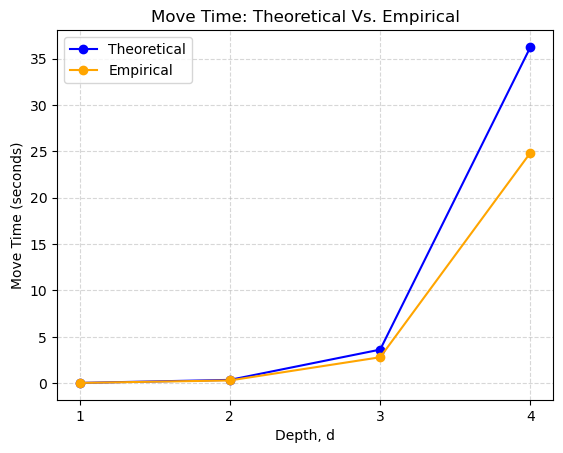

In [7]:
import matplotlib.pyplot as plt

# Depth range and move_time_sample_means dictionary
d_range = np.arange(1, 5)

theoretical_move_times = T_bar * b**d_range
empirical_move_times = list(move_time_sample_means.values())

# Plot the mean value for T (T_bar) against move_time_sample_means
plt.plot(d_range, theoretical_move_times, label='Theoretical', color='blue', marker='o')
plt.plot(d_range, empirical_move_times, label='Empirical', color='orange', marker='o')

plt.xlabel('Depth, d')
plt.ylabel('Move Time (seconds)')
plt.title('Move Time: Theoretical Vs. Empirical')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xticks(d_range)
plt.show()

- Observed data agrees with theory.
- Confirms our understanding of how Minimax's move-time scales with depth in Othello.
- Additionally, this indicates that $d = 3$ is a suitable depth for users to play against.